In [3]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, SeasonalNaive)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df


[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-02-01,AAPL,0.039523
1,2019-03-01,AAPL,0.096882
2,2019-04-01,AAPL,0.054901
3,2019-05-01,AAPL,-0.136476
4,2019-06-01,AAPL,0.126521
...,...,...,...
467,2023-08-01,NVDA,0.054674
468,2023-09-01,NVDA,-0.126301
469,2023-10-01,NVDA,-0.064464
470,2023-11-01,NVDA,0.137050


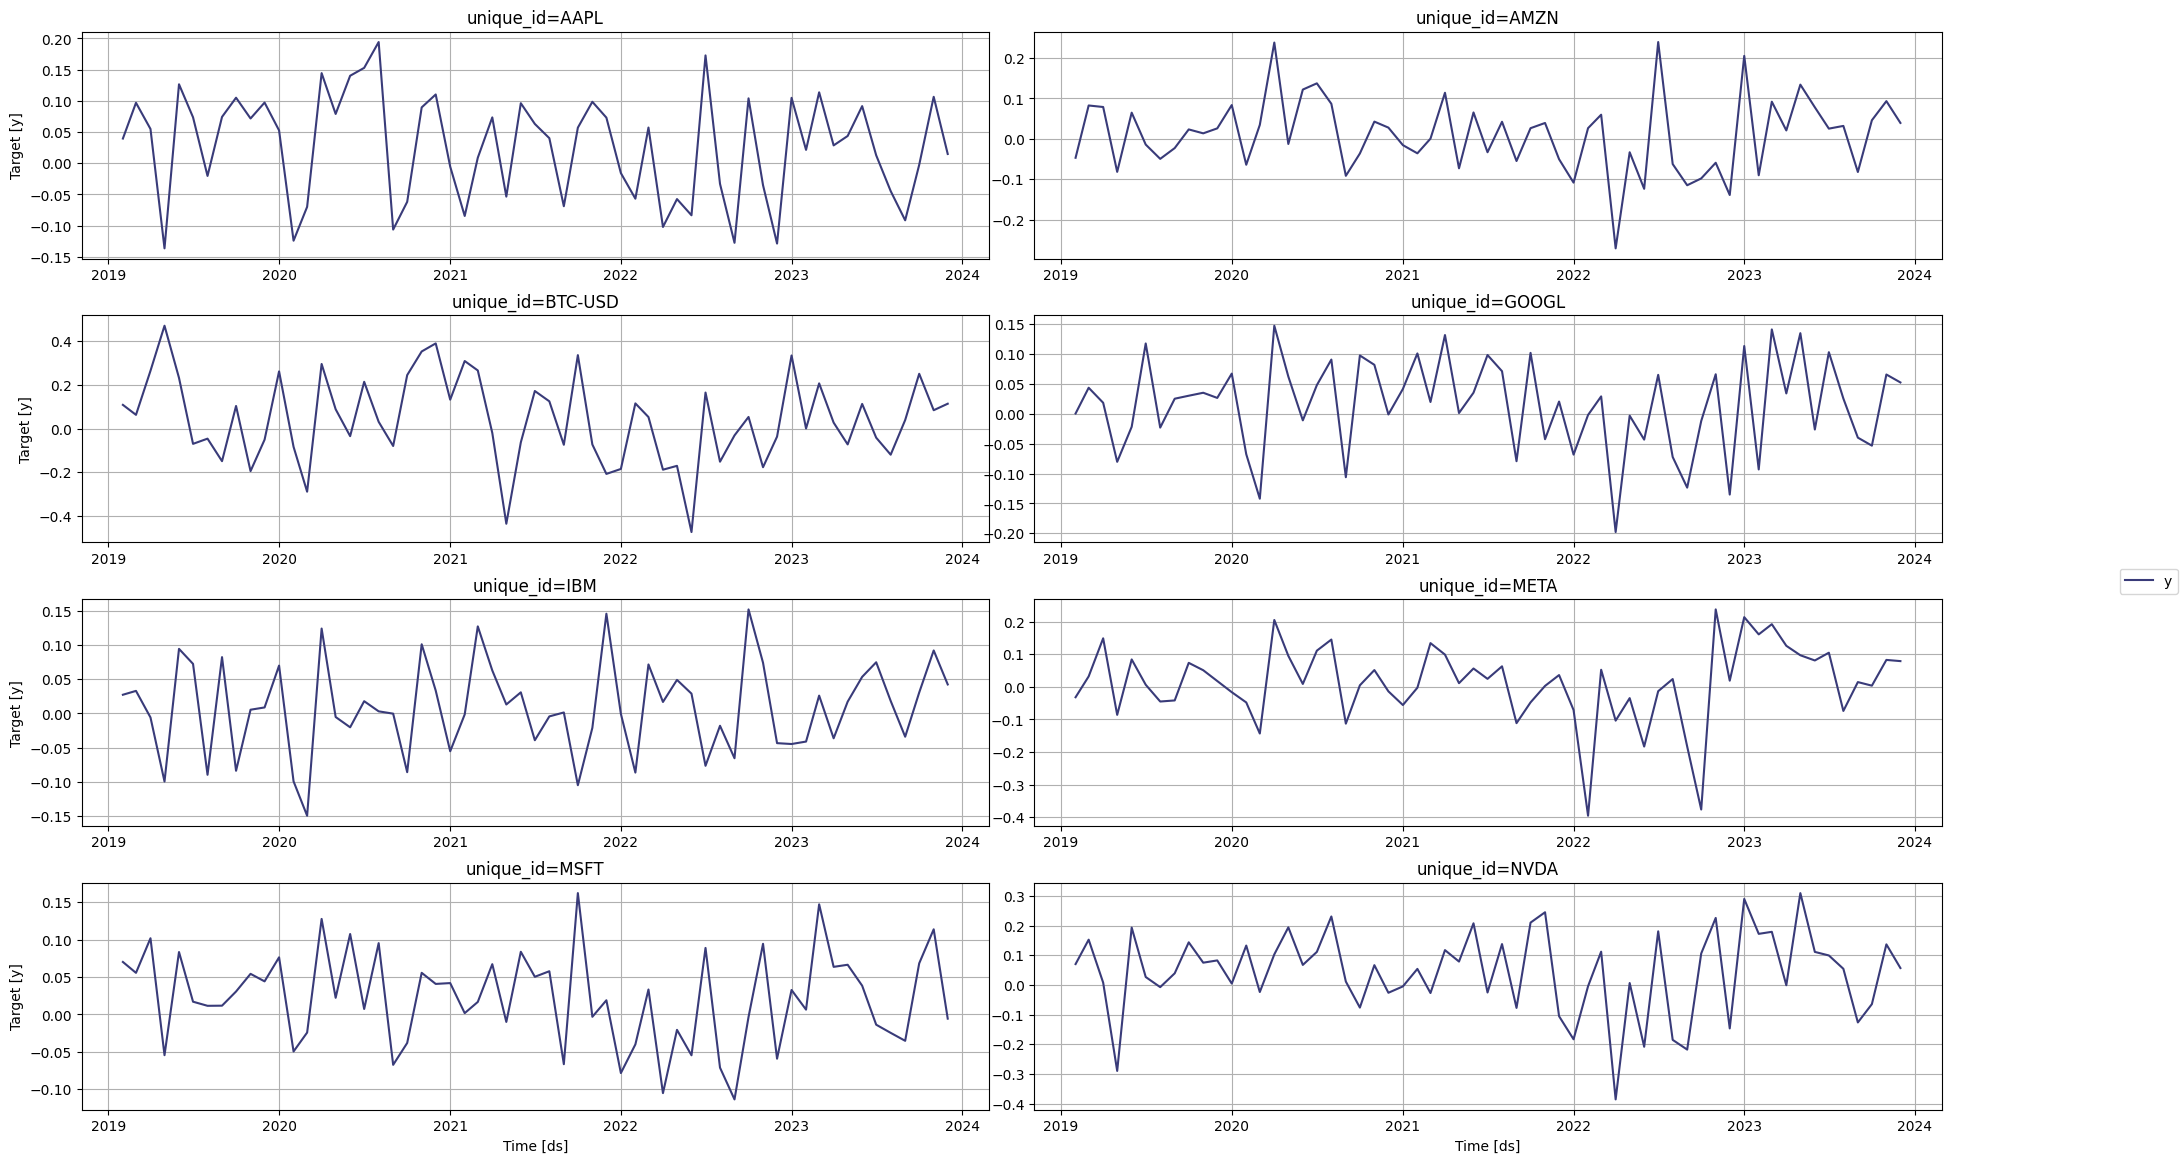

In [5]:
StatsForecast.plot(Y_df)

In [6]:
season_length = 12
horizon = 3

models = [
    AutoARIMA(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [7]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,AutoARIMA,SeasonalNaive
unique_id,,,
AAPL,2024-01-01,0.021517,0.104829
AAPL,2024-02-01,0.004391,0.021393
AAPL,2024-03-01,0.023327,0.113647
AMZN,2024-01-01,0.000000,0.205174
AMZN,2024-02-01,0.000000,-0.090252


In [8]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
AAPL,2022-10-01,2022-09-01,0.103956,0.017409,-0.129307,0.164126,0.057001,-0.125570,0.239573
AAPL,2022-11-01,2022-09-01,-0.035243,0.030072,-0.116644,0.176788,0.098461,-0.084110,0.281032
AAPL,2022-12-01,2022-09-01,-0.128762,0.022315,-0.124402,0.169031,0.073061,-0.109510,0.255633
AAPL,2023-01-01,2022-12-01,0.104829,-0.004202,-0.153418,0.145014,-0.015837,-0.203390,0.171716
AAPL,2023-02-01,2022-12-01,0.021393,-0.015085,-0.164301,0.134130,-0.056855,-0.244409,0.130698


In [9]:
cv_df.tail()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
NVDA,2023-08-01,2023-06-01,0.054674,0.0,-0.250984,0.250984,-0.185089,-0.537677,0.167498
NVDA,2023-09-01,2023-06-01,-0.126301,0.0,-0.250984,0.250984,-0.217874,-0.570462,0.134714
NVDA,2023-10-01,2023-09-01,-0.064464,0.0,-0.247008,0.247008,0.106341,-0.240501,0.453183
NVDA,2023-11-01,2023-09-01,0.137050,0.0,-0.247008,0.247008,0.226206,-0.120636,0.573048
NVDA,2023-12-01,2023-09-01,0.057175,0.0,-0.247008,0.247008,-0.146438,-0.493280,0.200404


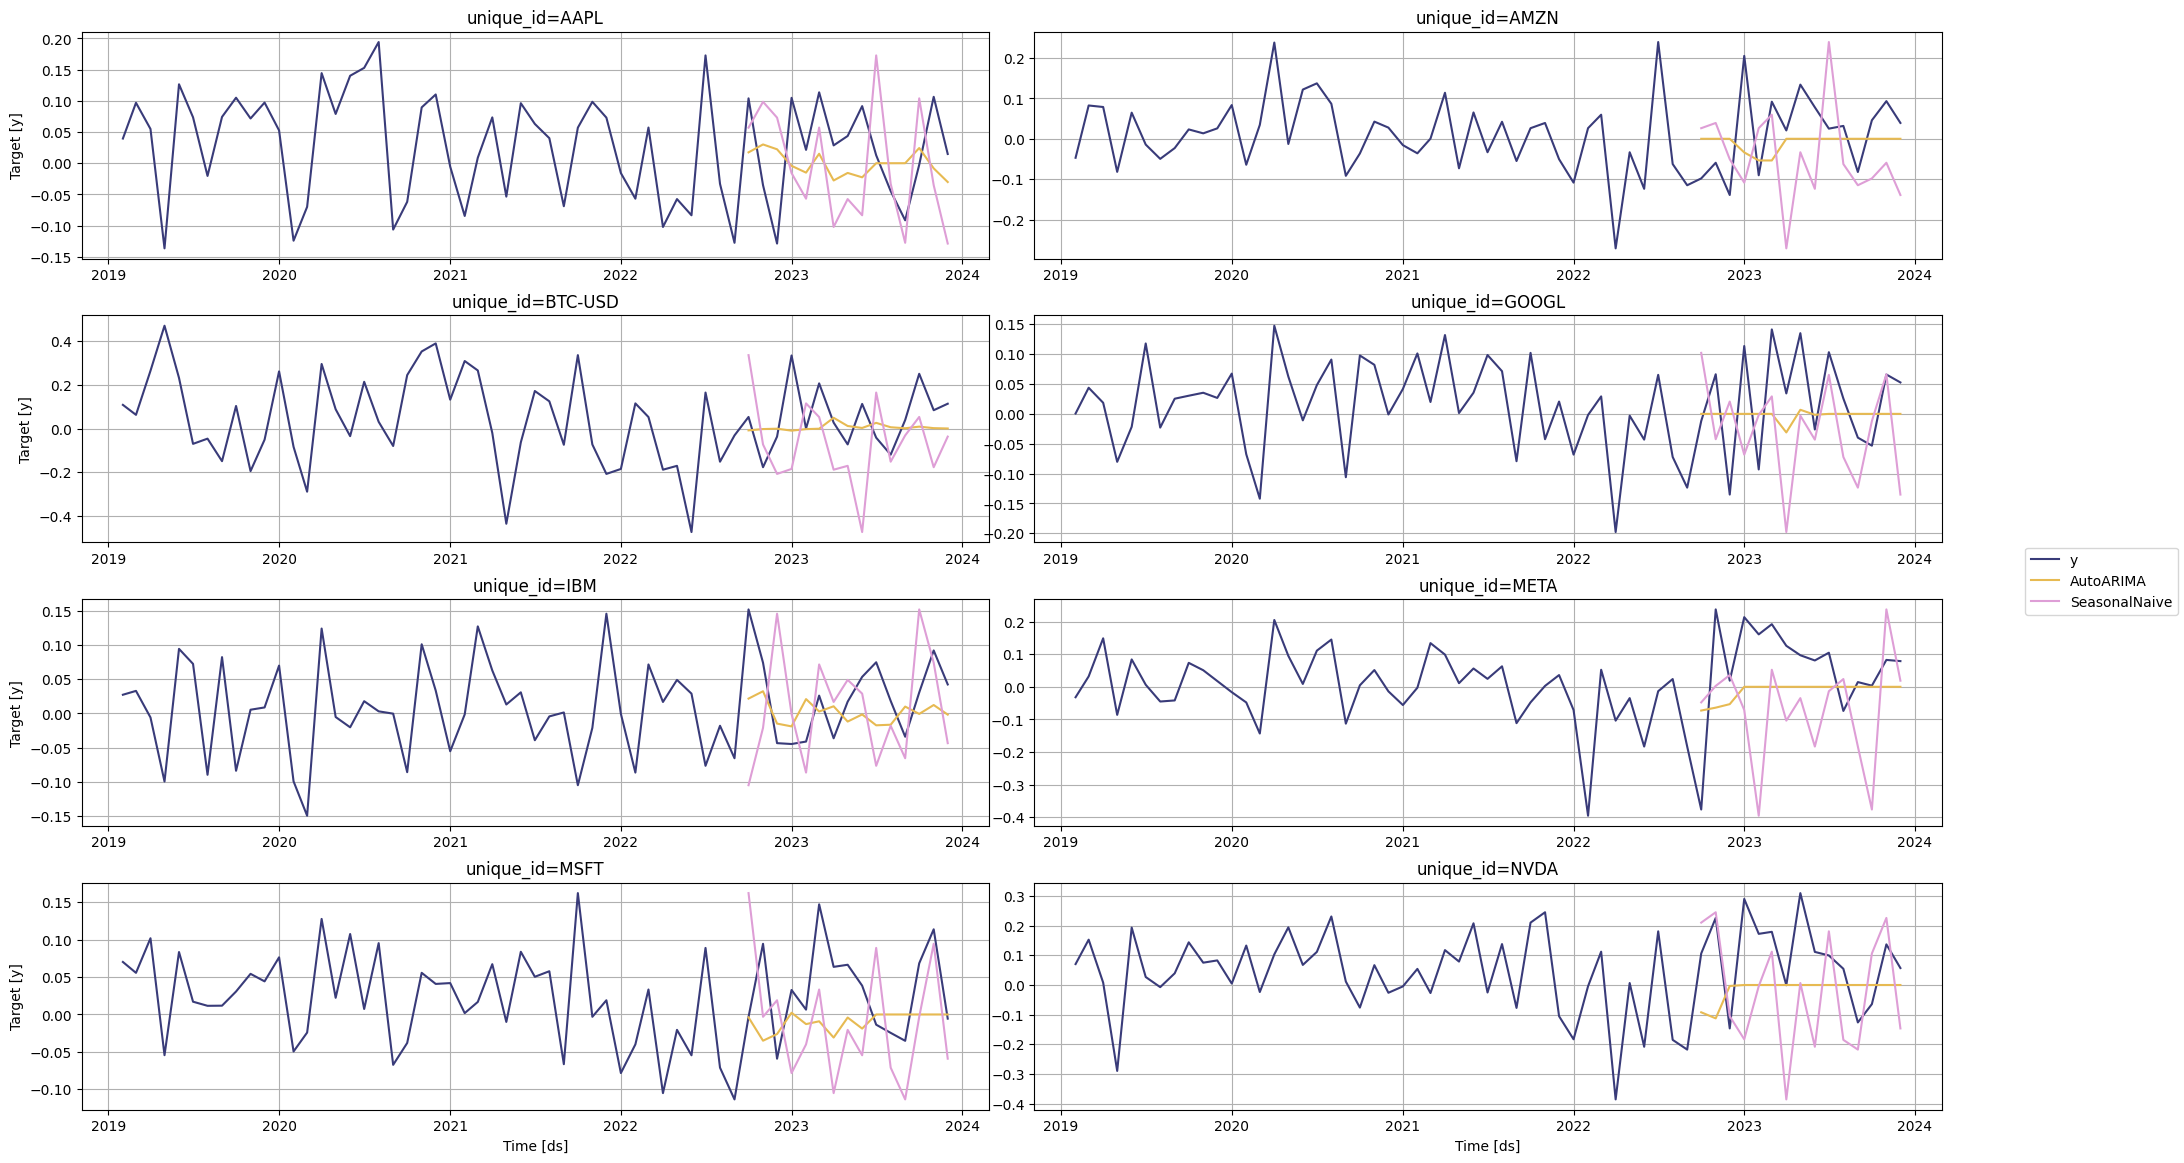

In [10]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [11]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [12]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [13]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [14]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [15]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 15:09:31,383 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 693d117cb12b2be62c40eba50ddf13a0 initialized by task ('shuffle-transfer-693d117cb12b2be62c40eba50ddf13a0', 7) executed on worker tcp://127.0.0.1:57110
2024-07-09 15:09:33,547 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 693d117cb12b2be62c40eba50ddf13a0 deactivated due to stimulus 'task-finished-1720530573.5391722'


,unique_id,cutoff,metric,AutoARIMA,SeasonalNaive
0,AAPL,2022-12-01,mse,0.007639,0.007958
1,AAPL,2022-12-01,mae,0.08133,0.085135
2,AAPL,2022-12-01,smape,184.302765,155.382736
3,AAPL,2023-06-01,mse,0.00351,0.009022
4,AAPL,2023-06-01,mae,0.049624,0.069237


In [16]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

AutoARIMA  SeasonalNaive
cutoff     metric                           
2022-09-01 mae         0.1169       0.135725
           mse       0.021889       0.024705
           smape    169.84259      151.66362
2022-12-01 mae       0.128908         0.1665
           mse        0.02464       0.050057
           smape   184.164139     158.108002
2023-03-01 mae       0.082338        0.18533
           mse       0.010365       0.050736
           smape   191.955963     178.183289
2023-06-01 mae       0.058593       0.097938
           mse       0.004702       0.013699
           smape   199.419586     132.440857
2023-09-01 mae       0.072533       0.130567
           mse       0.007611       0.023997
           smape   197.009598     152.705444

In [17]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

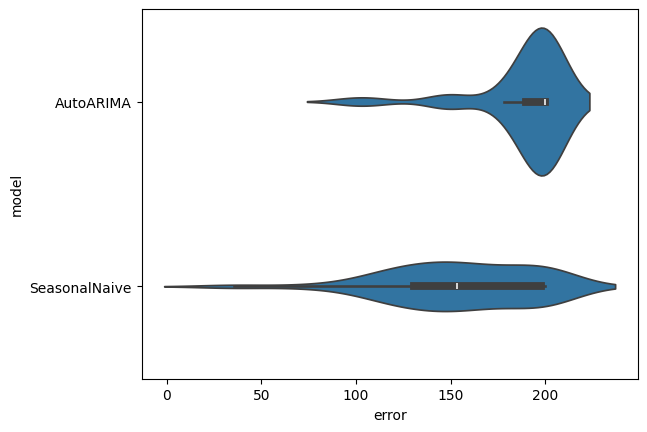

In [18]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

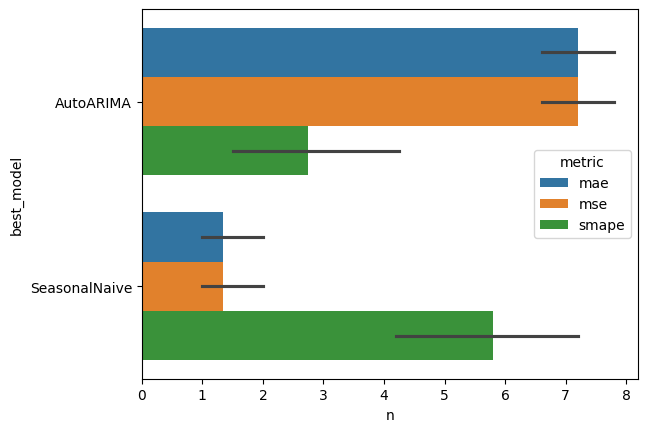

In [19]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')